# Latent Dirichlet Allocation (LDA)

In [1]:
import os
import re
import json
import gensim
import pyLDAvis
import random

import numpy as np
import pandas as pd

from gensim.models.ldamulticore import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel

from sklearn.model_selection import train_test_split

import lib.helper as helper
import lib.reporter as reporter

from nltk.stem.porter import *

# Define which stemmer to use in the pipeline later
stemmer = PorterStemmer()

import seaborn as sns
import pyLDAvis.gensim as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\ProgramData\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
C:\ProgramData\Anaconda3\lib\site-packages\nltk\lm\vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable


## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "disaster" corpus works likewise, but with keywords relating to natural disasters

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "RSS"

# Load up
corpus = helper.load_clean_world_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 495
9.9 percent of files read.
19.8 percent of files read.
29.7 percent of files read.
39.6 percent of files read.
49.5 percent of files read.
59.4 percent of files read.
69.3 percent of files read.
79.2 percent of files read.
89.1 percent of files read.
99.0 percent of files read.
(31393, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,Hurricane Dorian lashes US as Bahamas counts cost,"Life-threatening US storm surges are feared, a...","Thu, 05 Sep 2019 16:03:44 GMT",https://www.bbc.co.uk/news/world-us-canada-495...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Hurricane Dorian lashes US as Bahamas counts c...
1,1,Kohistan video murders: Three guilty in 'honou...,They are relatives of a group of Pakistani wom...,"Thu, 05 Sep 2019 13:53:17 GMT",https://www.bbc.co.uk/news/world-asia-49592540,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Kohistan video murders: Three guilty in 'honou...
2,2,MH17 Ukraine plane crash: 'Key witness' released,A Ukrainian court releases a potentially key w...,"Thu, 05 Sep 2019 13:46:06 GMT",https://www.bbc.co.uk/news/world-europe-49591148,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,MH17 Ukraine plane crash: 'Key witness' releas...
3,3,Article 370: The weddings 'ruined' by Kashmir'...,Indian-administered Kashmir is under a securit...,"Thu, 05 Sep 2019 07:32:34 GMT",https://www.bbc.co.uk/news/world-asia-india-49...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Article 7: The weddings 'ruined' by Kashmir's ...
4,4,Syria war: Turkey warns Europe of new migrant ...,President Erdogan demands international help t...,"Thu, 05 Sep 2019 16:11:48 GMT",https://www.bbc.co.uk/news/world-europe-49599297,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Syria war: Turkey warns Europe of new migrant ...


## 2.  Additional preprocessing for LDA

In [3]:
# Get simple cleaned + stem tokens
corpus["tokens"] = corpus["clean_text"].apply(helper.preprocess_description)

# Get phrase-conjoined, stem tokens
corpus['phrase_tokens'] = helper.get_phrased_nouns(corpus['clean_text'])

corpus.tail()

,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text,tokens,phrase_tokens
node,,,,,,,,,,,
31388,1107287,"‘Brit’ woman, 21, ‘raped in park at 4am after ...",A 21 year old British woman has allegedly been...,"Wed, 01 Jul 2020 06:30:54 +0000",https://www.thesun.co.uk/news/11997282/brit-wo...,https://www.thesun.co.uk/news/worldnews/feed,2020-07-01 10:34:07.844080,rss_feed,"‘Brit’ woman, 1, ‘raped in park at 4am after b...","[brit, woman, rape, park, stalk, predat, costa...","[park, costa, brava, costa, brava, lloret, mar..."
31389,1107288,Baby girl born with no arms or legs due to rar...,A BABY girl born without any arms or legs due ...,"Tue, 30 Jun 2020 21:23:31 +0000",https://www.thesun.co.uk/news/11995657/baby-bo...,https://www.thesun.co.uk/news/worldnews/feed,2020-07-01 10:34:07.844080,rss_feed,Baby girl born with no arms or legs due to rar...,"[babi, girl, born, arm, leg, rare, genet, diso...","[india, babi, india, madhya_pradesh, sakla, si..."
31390,1107294,Coronavirus second wave in Australia forces ro...,HUNDREDS of thousands of people in one of Aust...,"Tue, 30 Jun 2020 14:46:38 +0000",https://www.thesun.co.uk/news/11990427/coronav...,https://www.thesun.co.uk/news/worldnews/feed,2020-07-01 10:34:07.844080,rss_feed,Coronavirus second wave in Australia forces ro...,"[coronaviru, second, wave, australia, forc, ro...","[coronaviru, australia, glimps, britain, hundr..."
31391,1107499,"‘So Far, So V’: Bank of England Predicts Quick...",The UK’s central bank has recently improved it...,"Wed, 01 Jul 2020 06:02:16 +0000",https://sputniknews.com/uk/202007011079763634-...,https://sputniknews.com/export/rss2/world/inde...,2020-07-01 10:34:08.664116,rss_feed,"‘So Far, So V’: Bank of England Predicts Quick...","[far, bank, england, predict, quick, econom, b...","[bank_england, quick, econom, uk, gdp]"
31392,1107500,"'Faulty Masks' Sent to UK Care Homes Recalled,...",The PPE that has currently been generating con...,"Wed, 01 Jul 2020 05:37:11 +0000",https://sputniknews.com/uk/202007011079763390-...,https://sputniknews.com/export/rss2/world/inde...,2020-07-01 10:34:08.664116,rss_feed,"'Faulty Masks' Sent to UK Care Homes Recalled,...","[faulti, mask, sent, uk, care, home, recal, sp...","[faulti, mask, uk, care_home, fear, uk_covid]"


In [4]:
corpus.sample(5)[['title', 'summary', 'tokens', 'phrase_tokens']].reset_index()

,node,title,summary,tokens,phrase_tokens
0,16968,Hanau shooting: Suspect found dead in home wit...,A man suspected of killing ten people in the G...,"[hanau, shoot, suspect, dead, home, bodi, take...","[hanau, suspect, hanau]"
1,14826,Why China’s LGBT hide their identities at Luna...,Representation of China's LGBT community is im...,"[china, lgbt, hide, ident, lunar, new, year, r...","[china_lunar, new_year, represent, china_lunar..."
2,17860,Beckham on his US club Inter Miami's MLS debut,"Co-owner David Beckham describes his ""persever...","[beckham, club, inter, miami, ml, debut, owner...","[beckham, inter, miami, ml, david, beckham, in..."
3,722,Hong Kong protests: Chinese military begins pa...,Trump suggests trade deal with China can wait ...,"[hong, kong, protest, chines, militari, begin,...","[hong_kong, trump, xi_jinp, trump_china, hong_..."
4,20619,Coronavirus: Germany bans gatherings of more t...,'The danger lies in the direct social interact...,"[coronaviru, germani, ban, gather, peopl, dang...",[coronaviru_germani]


In [5]:
# Create the vocabulary record
dictionary = gensim.corpora.Dictionary(corpus['phrase_tokens'])

# Remove extreme values (words that are too rare, too common)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Create a BOW model
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus['tokens']]

# From that create the TF-IDF model
# THIS IS ANOTHER POINT THE CORPUS ORDERING COULD DETATCH FROM THE RAW DATA ORDERING
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus['corpus_tfidf'] = tfidf[bow_corpus]

corpus['corpus_tfidf'].head()

node
0    [(19, 0.6880293794601011), (107, 0.32507775470...
1    [(164, 0.34744078002012607), (684, 0.353091714...
2    [(2, 0.5966251690695155), (3, 0.18016049998921...
3    [(4, 0.28799477541580654), (5, 0.7726699154147...
4    [(6, 0.2383387196218237), (8, 0.49329758375633...
Name: corpus_tfidf, dtype: object

## 3. Testing a range of different-sized LDA models

In [6]:
random.seed(7)
trainset, testset = train_test_split(corpus, test_size=0.15)

In [7]:
# Loop through a number of different topic model sizes

results = pd.DataFrame()
for num_topics in range(40, 121):

    # Fit the lda model, with [num_topics] topics
    lda_model_tfidf = LdaModel(trainset['corpus_tfidf'],
                               num_topics=num_topics,
                               id2word=dictionary,
                               passes=2)
    
    # Get the perplexity
    perplexity = lda_model_tfidf.log_perplexity(testset['corpus_tfidf'])
    
    # Get the coherence - using Umass here because it's fast to calculate
    cm = CoherenceModel(model=lda_model_tfidf, corpus=testset['corpus_tfidf'], coherence='u_mass')
    coherence = cm.get_coherence()
    
    # record
    results = results.append({"topics":num_topics, "perplexity":perplexity, "coherence":coherence}, ignore_index=True)
    
    # Report for my convenience
    print("tried {} topics".format(num_topics), "perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

results.to_csv("working/disaster_lda_stats_clean.csv")

tried 40 topics perplexity = -13.96978377483156 coherence = -14.668371770481182
tried 41 topics perplexity = -14.085943289731897 coherence = -14.402723833345403
tried 42 topics perplexity = -14.289118826857928 coherence = -15.41926548412399
tried 43 topics perplexity = -14.566381262500883 coherence = -14.934591366755647
tried 44 topics perplexity = -14.757179819701156 coherence = -15.176052802145934
tried 45 topics perplexity = -15.085781752122916 coherence = -15.335687985136941
tried 46 topics perplexity = -15.322189870656535 coherence = -15.150994551198135
tried 47 topics perplexity = -15.847867981091271 coherence = -15.205809255889056
tried 48 topics perplexity = -16.020975265103722 coherence = -15.17547848672239
tried 49 topics perplexity = -16.55046722096754 coherence = -15.221013835458962
tried 50 topics perplexity = -16.934341970116336 coherence = -14.900248220645022
tried 51 topics perplexity = -17.559270673157926 coherence = -15.18690602862853
tried 52 topics perplexity = -18.

In [8]:
results = pd.read_csv("working/disaster_lda_stats_clean.csv")

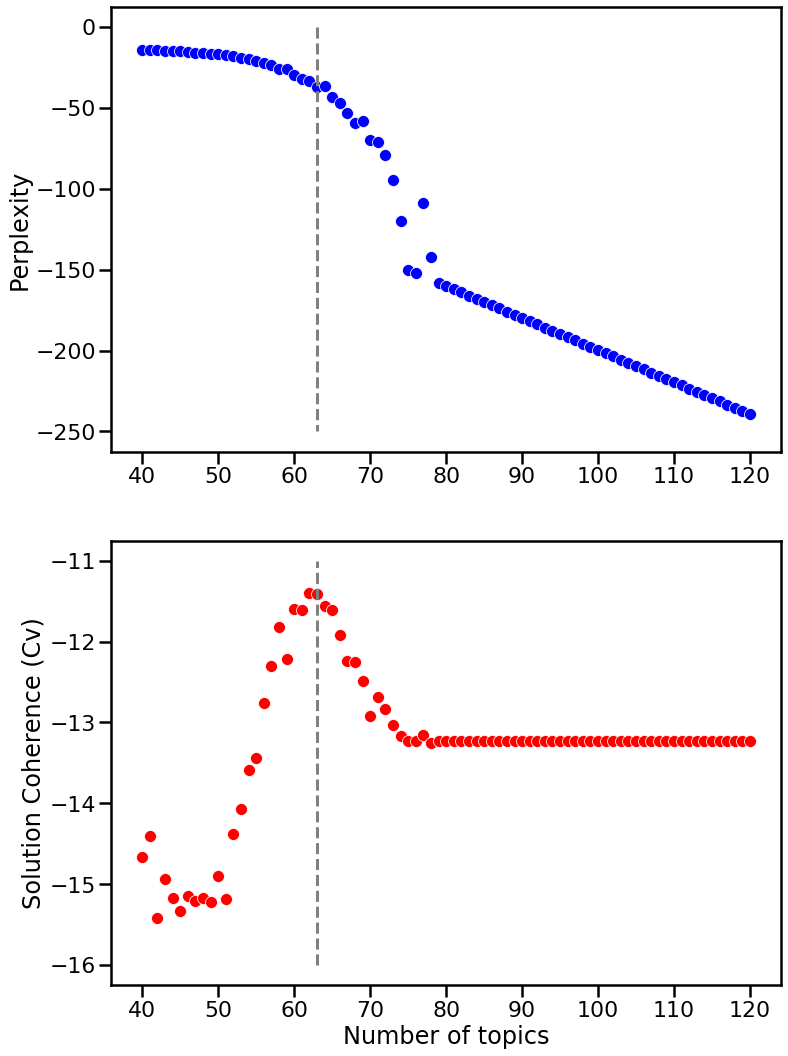

In [12]:
sns.set_context("poster")

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 18))
#fig.suptitle("LDA performance with topics")

axs[0].plot([63, 63], [0, -250], linestyle="--", color="grey")
sns.scatterplot(x="topics",
                y="perplexity",
                color="blue",
                data=results,
                ax=axs[0])

axs[0].set_xlabel("")
axs[0].set_ylabel("Perplexity")


axs[1].plot([63, 63], [-16, -11], linestyle="--", color="grey")
sns.scatterplot(x="topics",
                y="coherence",
                color="red",
                data=results,
                ax=axs[1])

axs[1].set_xlabel("Number of topics")
axs[1].set_ylabel("Solution Coherence (Cv)")

plt.savefig("outputs/lda_fitting.png")

## 4. Create the "best" model using all data

And parameters decided by test-time performance on perplexity and coherence.

In [11]:
random.seed(42)

# Fit the final lda model to all data
lda_model_tfidf = LdaModel(corpus['corpus_tfidf'],
                           num_topics=63,
                           id2word=dictionary,
                           passes=2)

# Get the perplexity, out of curiosity
perplexity = lda_model_tfidf.log_perplexity(corpus['corpus_tfidf'])
    
# Get the coherence, out of curiosity
cm = CoherenceModel(model=lda_model_tfidf, corpus=corpus['corpus_tfidf'], coherence='u_mass')
coherence = cm.get_coherence()

print("perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

#lda_model_tfidf.save("working/lda_model_tfidf.model")

perplexity = -40.873119363176876 coherence = -10.677361590476817


In [12]:
# Let's take a quick look at the topics picked out
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.061*"australia" + 0.061*"itali" + 0.043*"way" + 0.037*"parti" + 0.036*"know" + 0.033*"mark" + 0.032*"drop" + 0.032*"centr" + 0.030*"govern" + 0.028*"book"
Topic: 1 Word: 0.236*"home" + 0.151*"day" + 0.101*"babi" + 0.089*"onlin" + 0.060*"tv" + 0.052*"mum" + 0.042*"fli" + 0.033*"parad" + 0.028*"newborn" + 0.027*"met"
Topic: 2 Word: 0.000*"raf" + 0.000*"warrick" + 0.000*"ra" + 0.000*"ain" + 0.000*"hagibi" + 0.000*"troll" + 0.000*"franci" + 0.000*"hillari" + 0.000*"number" + 0.000*"hyde"
Topic: 3 Word: 0.000*"raf" + 0.000*"warrick" + 0.000*"ra" + 0.000*"ain" + 0.000*"hagibi" + 0.000*"troll" + 0.000*"franci" + 0.000*"hillari" + 0.000*"number" + 0.000*"hyde"
Topic: 4 Word: 0.121*"near" + 0.120*"great" + 0.099*"canada" + 0.073*"board" + 0.073*"tourist" + 0.072*"red" + 0.071*"shark" + 0.057*"green" + 0.056*"wit" + 0.041*"seal"
Topic: 5 Word: 0.000*"raf" + 0.000*"warrick" + 0.000*"ra" + 0.000*"ain" + 0.000*"hagibi" + 0.000*"troll" + 0.000*"franci" + 0.000*"hillari" + 0.000*"num

In [13]:
# Let's take a quick look at words the topics picked out
topic_word_dist = pd.DataFrame()

for idx, topic in lda_model_tfidf.print_topics(-1):
    
    # Record the topic index in a format R will like
    topic_index = "X" + str(idx)
    
    # Record the topic's key words as a single string
    # Split the words with a newline character while we're at it!
    topic_words = " ".join([x.split("*")[1].replace('"', '').strip() for x in topic.split("+")][0:5])
    
    # Dump them to the results dataframe
    topic_word_dist = topic_word_dist.append({"topic":topic_index, "keywords":topic_words}, ignore_index=True)
    
topic_word_dist

,keywords,topic
0,australia itali way parti know,X0
1,home day babi onlin tv,X1
2,raf warrick ra ain hagibi,X2
3,raf warrick ra ain hagibi,X3
4,near great canada board tourist,X4
...,...,...
58,peopl world attack unit kill,X58
59,plan fight leader meet talk,X59
60,black celebr flight incid american,X60
61,trump presid claim donald news,X61


In [14]:
# Assign topic to document, also store the probability of that topic
doc_topics = []

count = 0
for index, row in corpus.iterrows():
    
    # Extract list of tuples of (topic, score) from the model for each doc
    topics = [x for x in lda_model_tfidf.get_document_topics(row['corpus_tfidf']) ]
    
    # Find the highest probability topic
    highest_scoring = sorted(topics, key=lambda x: x[1], reverse=True)[0]
    
    temp = {"node": int(index),
            "cluster": highest_scoring[0],
            "score": highest_scoring[1]}
    
    # Report processing progress!
    count = count + 1
    if count % 10000 == 0:
        print(count)
    
    doc_topics.append(temp)

doc_topic_dist = pd.DataFrame(doc_topics).set_index("node")

corpus = corpus.join(doc_topic_dist)

# If cluster is smaller than minimum limit, designate as outlier
cs_lookup = corpus['cluster'].value_counts().to_dict()
corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < 5) else x)

corpus.to_csv("working/RSS_clustered_lda.csv", index=False)

# What percentage are now classed as outliers?
print("Percent outlier: ", 100.0 * sum(corpus['cluster']==-1) / corpus.shape[0])

# How many unique clusters after all this?
print("Number of clusters: ", len(pd.unique(corpus['cluster'])))

10000
20000
30000
Percent outlier:  0.0
Number of clusters:  35


### Looking at the topic distribution, there's no obvious way to draw a line and cut off outliers

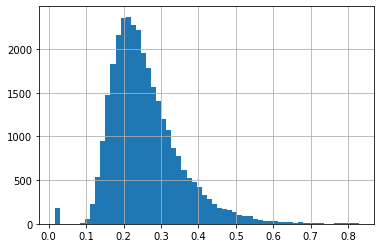

In [15]:
corpus['score'].hist(bins=60)